In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

%matplotlib inline

In [232]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [3]:
train_data=pd.read_csv('D:\Kaggle\competitive-data-science-predict-future-sales\sales_train_v2.csv')

In [4]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
train_data.shape

(2935849, 6)

In [6]:
items=pd.read_csv('items.csv')

In [7]:
items_category=pd.read_csv('item_categories.csv')

In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
items_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
items.shape

(22170, 3)

In [11]:
items_category.shape

(84, 2)

In [12]:
shop_data=pd.read_csv('shops.csv')

In [13]:
shop_data.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [14]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [15]:
train_data.date_block_num.nunique()

34

In [16]:
train_data.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], dtype=int64)

In [17]:
train_data.shop_id.unique()

array([59, 25, 24, 23, 19, 22, 18, 21, 28, 27, 29, 26,  4,  6,  2,  3,  7,
        0,  1, 16, 15,  8, 10, 14, 13, 12, 53, 31, 30, 32, 35, 56, 54, 47,
       50, 42, 43, 52, 51, 41, 38, 44, 37, 46, 45,  5, 57, 58, 55, 17,  9,
       49, 39, 40, 48, 34, 33, 20, 11, 36], dtype=int64)

In [18]:
train_data.item_id.nunique()

21807

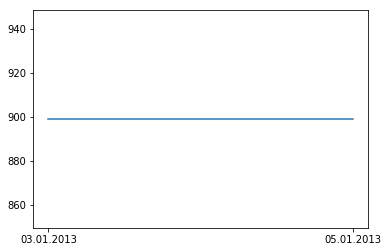

In [19]:
plt.plot(train_data.loc[(train_data.shop_id==25) & (train_data.item_id==2552),"date"],
         train_data.loc[(train_data.shop_id==25) & (train_data.item_id==2552),"item_price"])
plt.show()

In [20]:
train_data['sales']=train_data.item_price*train_data.item_cnt_day

In [21]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [22]:
train_data[abs(train_data.sales)!=train_data.item_price].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales
9,03.01.2013,0,25,2573,299.0,3.0,897.0
10,03.01.2013,0,25,2574,399.0,2.0,798.0
13,08.01.2013,0,25,2574,399.0,2.0,798.0
15,11.01.2013,0,25,2574,399.0,2.0,798.0
47,10.01.2013,0,25,2746,299.0,2.0,598.0


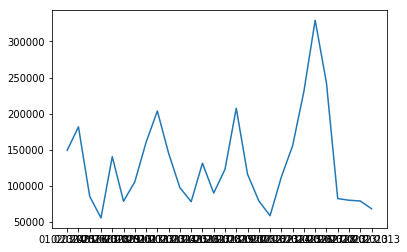

In [23]:
plot=train_data[(train_data.shop_id==0) & (train_data.date_block_num==1)].groupby(['date'],as_index=False)['sales'].sum()
plt.plot(plot.date,plot.sales)
plt.show()

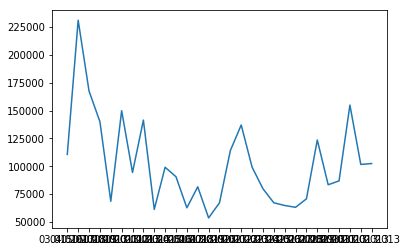

In [24]:
plot=train_data[(train_data.shop_id==0) & (train_data.date_block_num==0)].groupby(['date'],as_index=False)['sales'].sum()
plt.plot(plot.date,plot.sales)
plt.show()

In [25]:
count_item=train_data.groupby(['shop_id','item_id'])['date'].count().reset_index()

In [26]:
count_item.date.mean()

6.922147768105554

In [27]:
data_merged_cat=pd.merge(train_data,items,on="item_id")

In [28]:
data_merged_cat.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales,item_name,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,23.01.2013,0,24,22154,999.0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
2,20.01.2013,0,27,22154,999.0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
3,02.01.2013,0,25,22154,999.0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
4,03.01.2013,0,25,22154,999.0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37


In [29]:
data_merged_cat.item_category_id.unique()

array([37, 58, 56, 59, 55, 23, 19, 28, 30, 21, 40, 75, 49, 29, 22, 67, 73,
       77, 57, 60,  4, 62, 43, 15,  2,  3,  5, 68, 35, 33,  6, 38, 25, 14,
       45, 41, 66, 11, 69, 65, 82, 81, 64, 79, 63,  0, 70, 13, 83, 72, 61,
       71, 18,  9, 46,  1, 48, 10, 31, 76, 78, 54, 44, 52, 32, 39, 53, 12,
       20, 17,  8, 16, 51, 34, 24,  7, 74, 26, 27, 47, 50, 42, 80, 36], dtype=int64)

In [30]:
count_item_cat=data_merged_cat.groupby(['shop_id','item_category_id'])['date'].count().reset_index()

In [31]:
count_item_cat.date.mean()

897.5386731886273

In [32]:
count_item_cat.describe()

,shop_id,item_category_id,date
count,3271.000000,3271.000000,3271.000000
mean,29.763987,41.077346,897.538673
std,17.266164,24.174793,2629.419544
min,0.000000,0.000000,1.000000
25%,15.000000,20.000000,40.000000
50%,30.000000,40.000000,174.000000
75%,45.000000,63.000000,614.000000
max,59.000000,83.000000,62235.000000


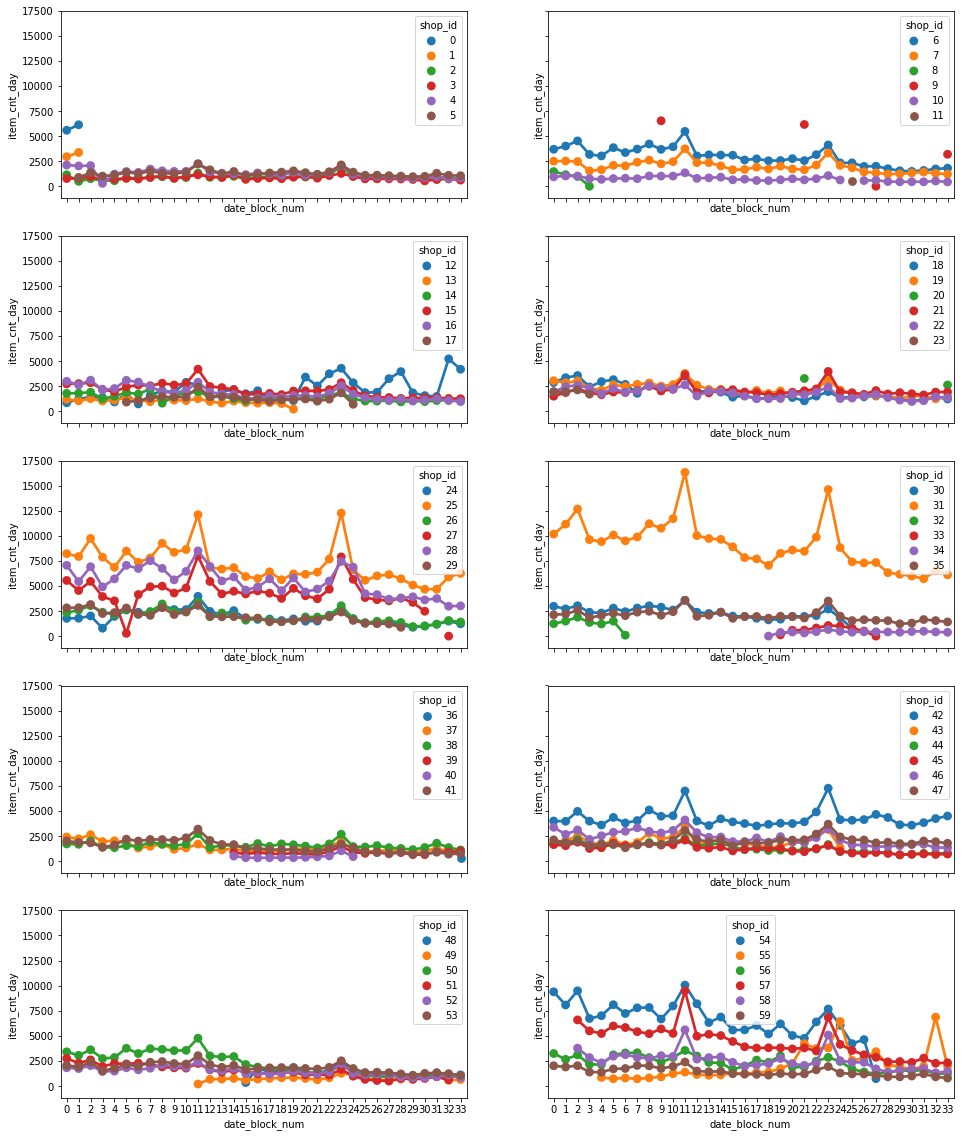

In [35]:
grouped = pd.DataFrame(train_data.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

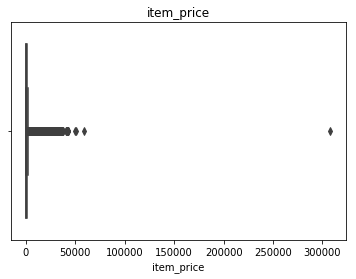

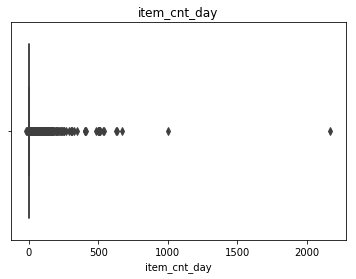

In [36]:
for col in ['item_price','item_cnt_day']:
    plt.figure()
    plt.title(col)
    sns.boxplot(x=train_data[col]);

In [57]:
for col in ['item_price','item_cnt_day']:
    perc_99=train_data[col].quantile(0.99)
    #max_val=train_data[col].max()
    train_data.loc[train_data[col]>perc_99,col]=perc_99

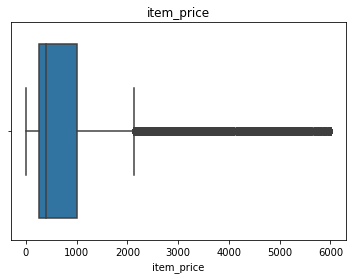

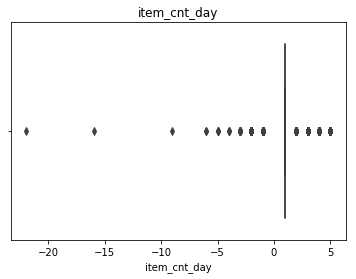

In [58]:
for col in ['item_price','item_cnt_day']:
    plt.figure()
    plt.title(col)
    sns.boxplot(x=train_data[col]);

In [60]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.049859e+02,1.165063e+00,1.157732e+03
std,9.422988e+00,1.622697e+01,6.324297e+03,9.594006e+02,6.171272e-01,5.683604e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,-6.897000e+04
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.490000e+02
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.490000e+02
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,1.078200e+03
max,3.300000e+01,5.900000e+01,2.216900e+04,5.999000e+03,5.000000e+00,1.829990e+06


In [67]:
train_data=train_data[train_data.item_price>=0]

In [68]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales
count,2.935848e+06,2.935848e+06,2.935848e+06,2.935848e+06,2.935848e+06,2.935848e+06
mean,1.456992e+01,3.300173e+01,1.019723e+04,8.049861e+02,1.165063e+00,1.157732e+03
std,9.422987e+00,1.622698e+01,6.324297e+03,9.594007e+02,6.171273e-01,5.683605e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,-2.200000e+01,-6.897000e+04
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.490000e+02
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.490000e+02
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,1.078200e+03
max,3.300000e+01,5.900000e+01,2.216900e+04,5.999000e+03,5.000000e+00,1.829990e+06


In [70]:
test_data=pd.read_csv('test.csv')

In [71]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [73]:
test_data["key"]=test_data["shop_id"].map(str) + test_data["item_id"].map(str)

In [74]:
list_key=test_data["key"].unique()

In [277]:
train_data["key"]=train_data["shop_id"].map(str)+train_data["item_id"].map(str)
train_data_subset=train_data[train_data["key"].isin(list_key)]

In [278]:
train_data_subset.shape

(1260865, 8)

In [279]:
train_data.shape

(2935848, 8)

In [280]:
train_data_subset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales,key
0,02.01.2013,0,59,22154,999.0,1.0,999.0,5922154
10,03.01.2013,0,25,2574,399.0,2.0,798.0,252574
11,05.01.2013,0,25,2574,399.0,1.0,399.0,252574
12,07.01.2013,0,25,2574,399.0,1.0,399.0,252574
13,08.01.2013,0,25,2574,399.0,2.0,798.0,252574


In [281]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [282]:
train_data_subset=downcast_dtypes(train_data_subset)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [283]:
train_data_subset.dtypes

date               object
date_block_num      int32
shop_id             int32
item_id             int32
item_price        float32
item_cnt_day      float32
sales             float32
key                object
dtype: object

In [284]:
train_data_subset["month"]=train_data_subset.date_block_num%12+1

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [285]:
agg_train=train_data_subset.groupby(['shop_id','item_id','date_block_num','month','year'],as_index=False).agg({'item_cnt_day':{'target':'sum','trips':'size'}})

KeyError: 'year'

In [ ]:
agg_train.columns = [col[0] if col[-1]=='' else col[-1] for col in agg_train.columns.values]

In [ ]:
agg_train.head()

In [ ]:
gb = train_data_subset.groupby(['date_block_num','item_id'],as_index=False).agg({'item_price':{'median_item_price':'median'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
agg_train = pd.merge(agg_train, gb, how='left', on=['date_block_num','item_id'])

In [ ]:
gb = agg_train.groupby(['item_id'],as_index=False).agg({'date_block_num':{'item_first_month':'min'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
agg_train = pd.merge(agg_train, gb, how='left', on=['item_id'])

In [ ]:
del gb

In [ ]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [ ]:
cols_to_rename = list(agg_train.columns.difference(index_cols+['item_first_month'])) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = agg_train[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    agg_train = pd.merge(agg_train, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013


agg_train = agg_train[agg_train['date_block_num'] >= 12] 
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
agg_train = pd.merge(agg_train, item_category_mapping, how='left', on='item_id')

In [ ]:
item_target_enc_na = .3343 # default na replacement
# Expanding Mean
cumsum = agg_train.groupby('item_id')['target'].cumsum() - agg_train['target']
cumcnt = agg_train.groupby('item_id')['target'].cumcount()

agg_train['item_target_enc'] = cumsum/cumcnt
agg_train['item_target_enc'].fillna(item_target_enc_na,inplace=True)
corr = np.corrcoef(agg_train['target'].values, agg_train['item_target_enc'])[0][1]
print(corr)

In [ ]:
item_target_enc_na = .3343 # default na replacement
# Expanding Mean
cumsum = agg_train.groupby('shop_id')['target'].cumsum() - agg_train['target']
cumcnt = agg_train.groupby('shop_id')['target'].cumcount()

agg_train['shop_id_enc'] = cumsum/cumcnt
agg_train['shop_id_enc'].fillna(item_target_enc_na,inplace=True)
corr = np.corrcoef(agg_train['target'].values, agg_train['shop_id_enc'])[0][1]
print(corr)

In [ ]:
agg_train.drop('shop_id_enc',axis=1,inplace=True)
agg_train.columns

In [ ]:
x_train=agg_train[agg_train.date_block_num<33].drop(["target","trips","date_block_num"],axis=1)
x_valid=agg_train[agg_train.date_block_num==33].drop(["target","trips","date_block_num"],axis=1)
y_train = agg_train.loc[agg_train['date_block_num'] < 33,'target'].values
y_val = agg_train.loc[agg_train['date_block_num'] == 33,'target'].values

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_val, reference=lgb_train)

# specify your initial configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'root_mean_squared_error'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 10
}

In [ ]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=15,
                valid_sets=[lgb_train,lgb_eval],
                valid_names=['train','val'],
                early_stopping_rounds=5)

print(gbm.pandas_categorical)
lgb.plot_importance(gbm,figsize=(10,10));

In [ ]:
categorical_features = ['shop_id','item_id']

lgb_train = lgb.Dataset(x_train, y_train,categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(x_valid, y_val, reference=lgb_train,categorical_feature=categorical_features)

gbm2 = lgb.train(params,
                lgb_train,
                num_boost_round=15,
                valid_sets=[lgb_train,lgb_eval],
                valid_names=['train','val'],
                categorical_feature = categorical_features,
                early_stopping_rounds=5)

print(gbm2.pandas_categorical)
lgb.plot_importance(gbm2,figsize=(10,10));

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train,categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(x_valid, y_val, reference=lgb_train,categorical_feature=categorical_features)

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':10 
              }

model = lgb.train(lgb_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train,lgb_eval],
                valid_names=['train','val'],
                categorical_feature = categorical_features,
                early_stopping_rounds=5)


print(model.pandas_categorical)
lgb.plot_importance(model,figsize=(10,10));